### Integrantes

Rafael Augusto Monteiro - 9293095  
William Quelho Ferreira - 9293421

# Exploração dos dados - Parte V

Datasets selecionados:
* Titanic


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('default')

## Titanic

In [12]:
path = "train.csv"

df = pd.read_csv(path)
df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


### Perguntas

1. O desbalanceamento, em geral, causa problemas para a classificação. Trate o desbalanceamento utilizando as abordagens de subamostragem, superamostragem. Para realizar a subamostragem e a superamostragem chame a função sample do DataFrame. Abaixo tem um exemplo de como utilizar essa função. Mostre a distribuição das classes após o balanceamento. Utilize a função classificação definida abaixo ajustando o parâmetro weights para um valor que você ache adequado. Esse parâmetro faz com que o algoritmo de classificação leve em conta o peso da classe no processo de treinamento. Utilize 2 valores de weights diferentes e comente o resultado (o que você acha que mudou com esses valores diferentes de weights). 

2. Faça a conversão entre tipos para dois atributos. Escolha as conversões que achar mais adequada, quantitativo para qualitativo ou qualitativo para quantitativo. Explique o que você fez e porque achou essa a melhor forma de fazer. Para referência consulte os slides 9-21.

3.  Realize a normalização de duas colunas. Para normalizar utilize a abordagem 0-1 (slide 27) e z-score (slide 29). Apresente métricas que comprove que a normalização foi realizada (boxplot, histograma, ...).



## Respostas

### 1-  Amostragens

#### Realizando diferentes amostragens

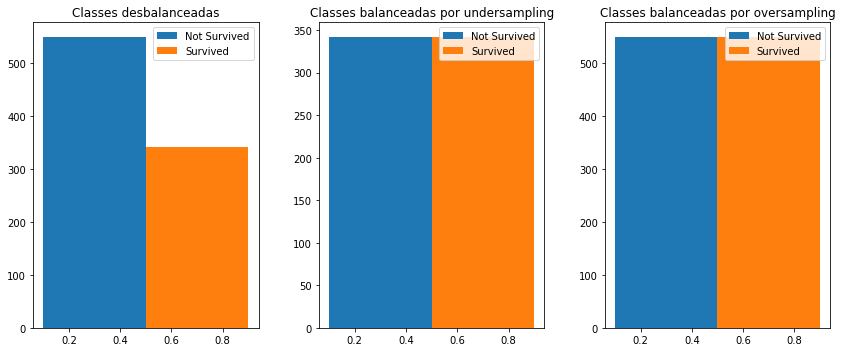

In [11]:
# calculando percentagem de cada classe
n_surv = df['Survived'].sum()
surv = df[df['Survived'] == 1]
not_surv = df[df['Survived'] == 0]

plt.figure(figsize=(12,5))
plt.subplot(131)
plt.title('Classes desbalanceadas')
plt.hist([not_surv['Survived'],surv['Survived']], label=['Not Survived','Survived'],bins=[0,1], align='mid')
plt.legend()

# w tem uma lista com 1 em cada instância do dataset que sobreviveu
w = df.loc[:,'Survived']
surv = df.sample(n=n_surv,weights=w,axis=0)
not_surv = df.sample(n=n_surv,weights=np.logical_not(w),axis=0)

plt.subplot(132)
plt.title('Classes balanceadas por undersampling')
plt.hist([not_surv['Survived'],surv['Survived']], label=['Not Survived','Survived'],bins=[0,1], align='mid')
plt.legend()

# juntando amostra de sobreviventes com amostra de nao sobreviventes  e aleatorizando com frac
undersampled = pd.concat([surv,not_surv],axis=0).sample(frac=1)


n_not_surv = len(df) - n_surv
diff_n = n_not_surv - n_surv

not_surv = df.sample(n=n_not_surv,weights=np.logical_not(w),axis=0)
surv_over = df.sample(n=diff_n, weights=w, axis=0)
surv = pd.concat([surv, surv_over], axis=0).sample(frac=1)

plt.subplot(133)
plt.title('Classes balanceadas por oversampling')
plt.hist([not_surv['Survived'],surv['Survived']], label=['Not Survived','Survived'],bins=[0,1], align='mid')
plt.legend()

plt.tight_layout()
plt.show()

oversampled = pd.concat([not_surv, surv_over], axis=0).sample(frac=1)

#### Rodando função de classificação com diferentes pesos

In [4]:
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from numpy import mean, std


def classificacao(data, columns, target, weights, title_prefix = ''):
    """
    Executa classificação do conjunto de dados passado
    ---------------------------------------------------------------
    data:       DataFrame. Conjunto de dados
    columns:    Lista de inteiros. Índice das colunas utilizadas no treinamento e teste
    target:     Inteiro. Índice da coluna alvo
    weights:    Dicionário. Pesos das classes, cada chave do dicionário é a classe e seu valor a probabilidade
    ---------------------------------------------------------------
    Realiza a classificação em 3 modelos (SVM com kernel linear, 
    SVM com kernel polinomial de grau 3, Árvore de decisão)
    Plot o gráfico de desempenho para cada classificador.
    Retorna um dicionário com os classificadores treinados e as medidas de desempenho
    """
    
    # inicializa os modelos com os parâmetros solicitados
    svm_l = SVC(C=10*len(data), kernel='linear', cache_size=500, max_iter=1e6, class_weight=weights)
    svm_n = SVC(C=10*len(data), kernel='poly', degree=3, gamma=1, coef0=1, cache_size=500, max_iter=1e6, class_weight=weights)
    dt = DecisionTreeClassifier(criterion='gini', splitter='best', min_samples_split=int(len(data)*0.1), class_weight=weights)
    
    clfs = [svm_l, svm_n, dt]
    clfs_names = ['svm_linear', 'svm_poly', 'dt']
    
    # prepara validação cruzada
    # faz divisão do dataset em 5 partes
    cv = KFold(n_splits=5, shuffle=True)
    
    # itera para cada classificador fazendo treino e teste
    results = {'svm_linear':[], 'svm_poly':[], 'dt':[]}
    for c, c_name in zip(clfs, clfs_names):
        for train_index, test_index in cv.split(data):
            
            # separa conjunto de treino e de teste
            x_train, y_train = data.iloc[train_index, columns], data.iloc[train_index, target]
            x_test, y_test = data.iloc[test_index, columns], data.iloc[test_index, target]
            
            # faz o treino do modelo
            clf = c.fit(X=x_train, y=y_train)
            
            # realiza predição no conjunto de teste e salva o resultado
            results[c_name].append( clf.score(x_test, y_test) )
    
    # faz o plot de desempenho dos classificadores
    plt.figure(figsize=(8,8))
    plt.bar(range(1, len(clfs)+1), [mean(results[name]) for name in clfs_names], 
                                yerr=[std(results[name]) for name in clfs_names])
    plt.xticks(range(1, len(clfs)+1), clfs_names, rotation=45)
    title = 'Desempenho dos classificadores - acurácia'
    plt.title(f'{title_prefix} {title}')
    plt.show()
    
    return {'results': results, 'clfs':clfs}

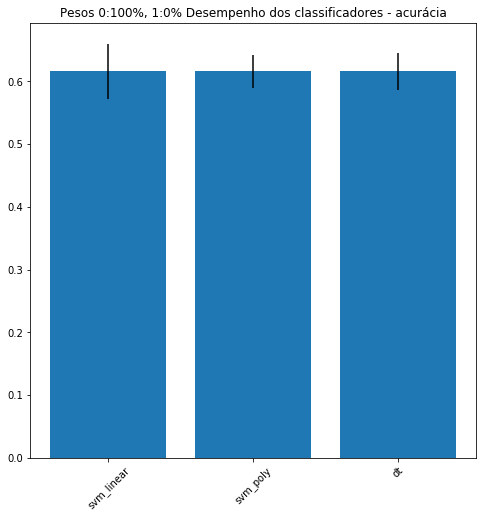

c:\program files\python37\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


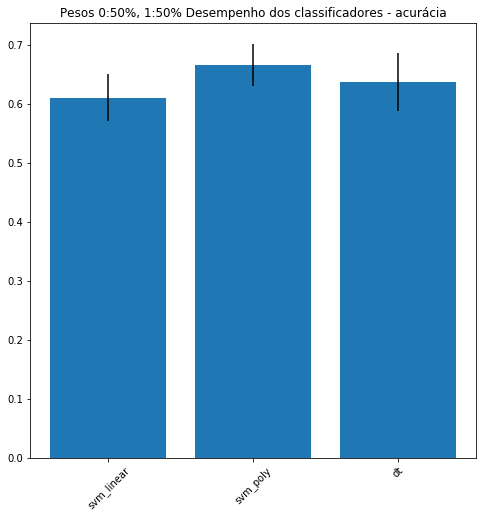

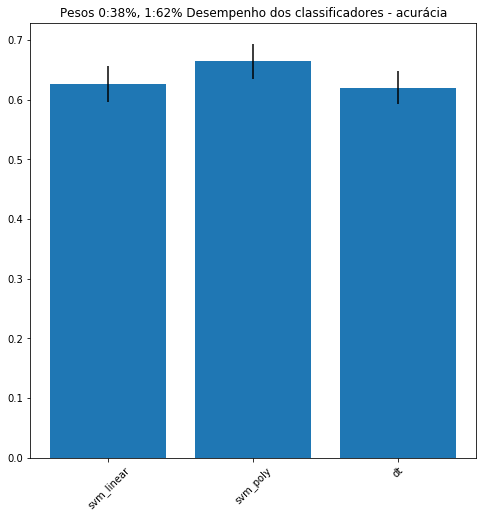

In [5]:
def normalize(dataframe):
    return (dataframe - dataframe.min())/(dataframe.max() - dataframe.min())

# Removendo os sem idade
clean = normalize(df.loc[:,['Age', 'SibSp', 'Parch','Survived']].dropna())

# Substituindo pela médiana
median = normalize(df.loc[:,['Age','SibSp', 'Parch','Survived']].fillna(np.round(clean['Age'].median())))
median.Survived = median.Survived.astype(int)

# Calculando probabilidades de cada classe
weights = {0:n_surv/len(median) , 1:1-(n_surv/len(median))}

cols = [0,1,2]
# Rodando classificador com pesos 

clf = classificacao(median, cols, 3, weights={0:1,1:0}, title_prefix='Pesos 0:100%, 1:0%')
clf = classificacao(median, cols, 3, weights={0:0.5,1:0.5}, title_prefix='Pesos 0:50%, 1:50%')
clf = classificacao(median, cols, 3, weights=weights, title_prefix=f'Pesos 0:{weights[0]:.0%}, 1:{weights[1]:.0%}')

### 2 - Conversão

Escolhemos converter o campo sex para dois campos: male e female. Essa é uma conversão qualitativa para quantitativa. Foi escolhida a transformação 1-para-n pois não existe relação de ordem entre male e female, não sendo possível apenas transformar a variável para valores binários.

In [6]:
# Rodando get_dummies em sex
converted = pd.get_dummies(df,columns=['Sex'])
converted.head(5)

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_female,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,1,0
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,1,0
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,0,1


### 3 - Normalização dos dados

Foi feita a normalização para o intervalo 0-1 na coluna SibSp e a normalização por Z-score na coluna Age. Para indicar o resultado das normalizações, foram plotados os boxplots antes e depois das normalizações.

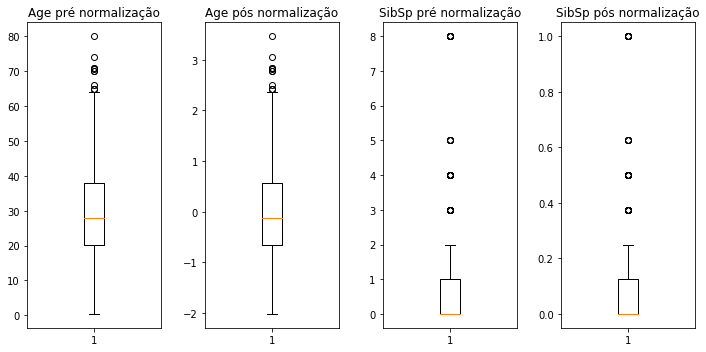

In [7]:
from scipy import stats

plt.figure(figsize=(10,5))
plt.subplot(141)
plt.title('Age pré normalização')
plt.boxplot(df.Age.dropna())

df_normalized_age = df.copy().dropna(subset=['Age'])
df_normalized_age.Age = stats.zscore(df_normalized_age.Age)

plt.subplot(142)
plt.title('Age pós normalização')
plt.boxplot(df_normalized_age.Age.dropna())

plt.subplot(143)
plt.title('SibSp pré normalização')
plt.boxplot(df.SibSp.dropna())

# normalizando a coluna Age por z-score
df.SibSp = (df.SibSp - df.SibSp.min()) / (df.SibSp.max() - df.SibSp.min())

plt.subplot(144)
plt.title('SibSp pós normalização')
plt.boxplot(df.SibSp.dropna())

plt.tight_layout()
plt.show()